In [1]:
!featurize dataset download 5653c901-0c4c-44e2-b542-294e5ae43f06

100%|██████████████████████████████████████| 49.7M/49.7M [00:00<00:00, 301MiB/s]
🍬  下载完成，正在解压...
🏁  数据集已经成功添加


In [2]:
import os
import shutil
import random
from pathlib import Path

def split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio):
    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios should add up to 1."
    
    # 创建目录结构
    subfolders = ['train', 'valid', 'test']
    for subfolder in subfolders:
        for category in categories:
            os.makedirs(os.path.join(dest_base_path, subfolder, category), exist_ok=True)
    
    # 分配图片到训练集、验证集和测试集
    for category in categories:
        category_path = Path(src_base_path) / category
        image_files = list(category_path.glob('*.*'))
        
        random.shuffle(image_files)
        
        train_count = int(len(image_files) * train_ratio)
        valid_count = int(len(image_files) * valid_ratio)
        
        train_files = image_files[:train_count]
        valid_files = image_files[train_count:train_count + valid_count]
        test_files = image_files[train_count + valid_count:]
        
        for file in train_files:
            shutil.copy(file, os.path.join(dest_base_path, 'train', category, file.name))
        
        for file in valid_files:
            shutil.copy(file, os.path.join(dest_base_path, 'valid', category, file.name))
        
        for file in test_files:
            shutil.copy(file, os.path.join(dest_base_path, 'test', category, file.name))



In [18]:
src_base_path = 'Untitled Folder'
dest_base_path = 'data'
categories = ['chevrolet', 'ford','honda','hyundai','kia','subaru','toyota','volkswagen']
train_ratio, valid_ratio, test_ratio = 0.6, 0.2, 0.2

split_dataset(src_base_path, dest_base_path, categories, train_ratio, valid_ratio, test_ratio)

In [19]:
!pip install fastai

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [20]:
!pip install ipywidgets

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [21]:
from fastai.vision.all import *
from fastai.vision.widgets import *

# 指定数据集路径
path = Path(dest_base_path)

In [22]:
item_tfms=Resize(224)
batch_tfms=aug_transforms()

In [23]:
dls = ImageDataLoaders.from_folder(path,
                                   train='train', 
                                   valid='valid', 
                                   seed=42, 
                                   item_tfms=item_tfms,
                                   batch_tfms=batch_tfms)

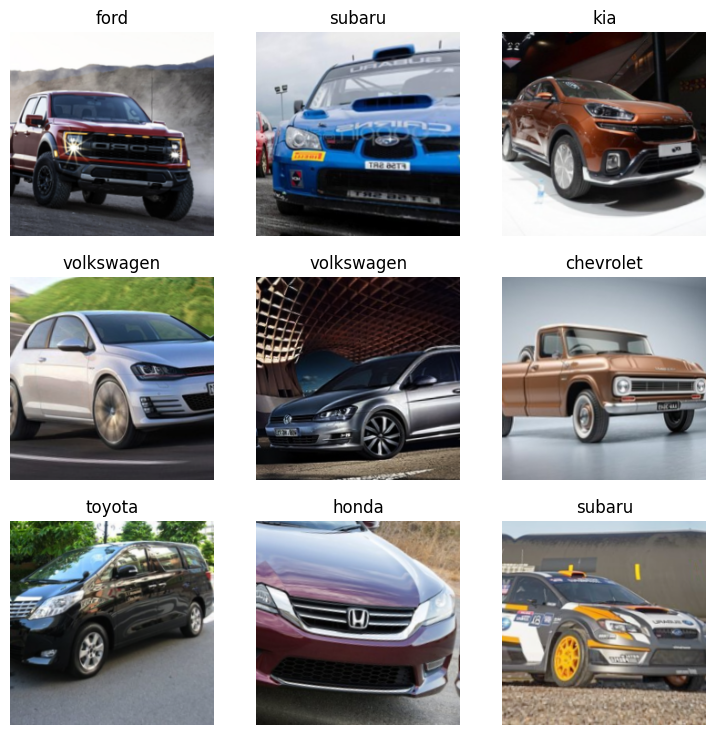

In [24]:
dls.show_batch()

In [25]:
arch = resnet18

In [26]:
learn = vision_learner(dls, arch, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 567MB/s]


SuggestedLRs(valley=0.0010000000474974513)

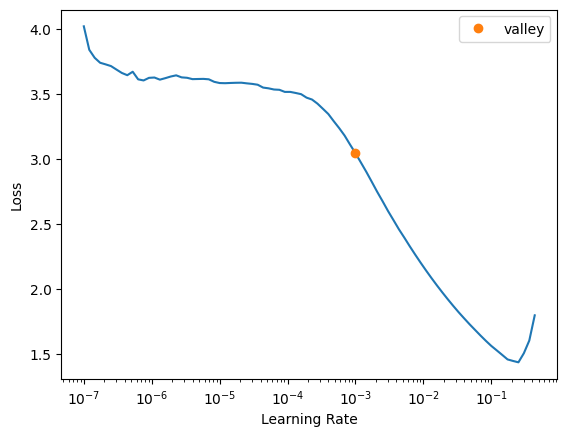

In [27]:
learn.lr_find()

In [32]:
# fine tune the model
learn.fine_tune(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.018376,0.966636,0.724138,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.009268,0.957143,0.724138,00:01
1,0.007621,0.944253,0.724138,00:01
2,0.007252,0.931121,0.724138,00:01
3,0.006863,0.906489,0.724138,00:01
4,0.006900,0.913894,0.724138,00:01


In [33]:
# fine tune the model
learn.fine_tune(5, 6e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.011308,0.918058,0.724138,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.000804,0.948839,0.724138,00:01
1,0.002509,0.856405,0.758621,00:01
2,0.001995,0.813801,0.793103,00:01
3,0.002063,0.816413,0.793103,00:01
4,0.002380,0.770654,0.793103,00:01


In [34]:
# fine tune the model
learn.fine_tune(5, 8e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.001992,0.742761,0.793103,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.001190,0.747375,0.758621,00:01
1,0.005395,1.131653,0.758621,00:01
2,0.006570,1.264399,0.758621,00:01
3,0.023131,1.095304,0.793103,00:01
4,0.018605,0.977811,0.793103,00:01


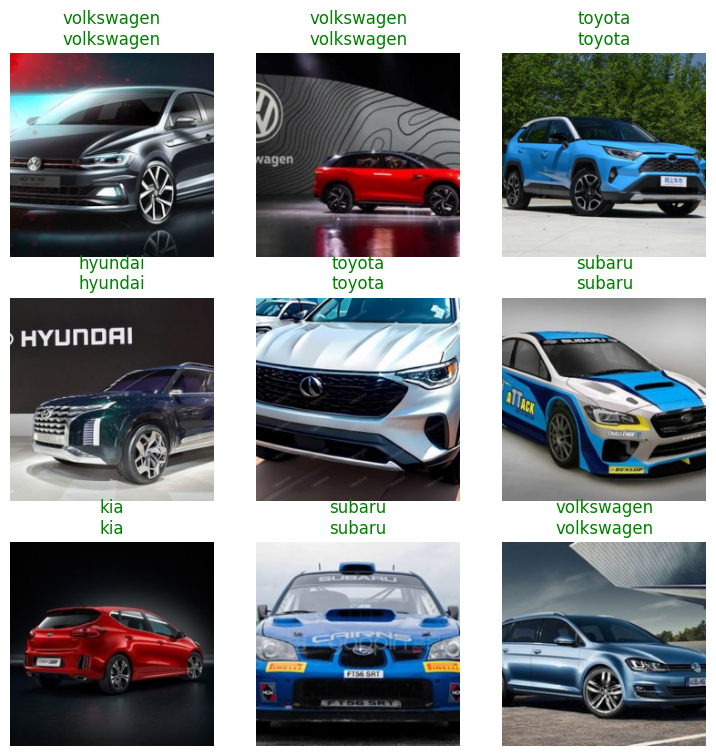

In [35]:
# show results
learn.show_results()

In [36]:
test_dl = dls.test_dl(get_image_files(path/'test'), with_labels=True)

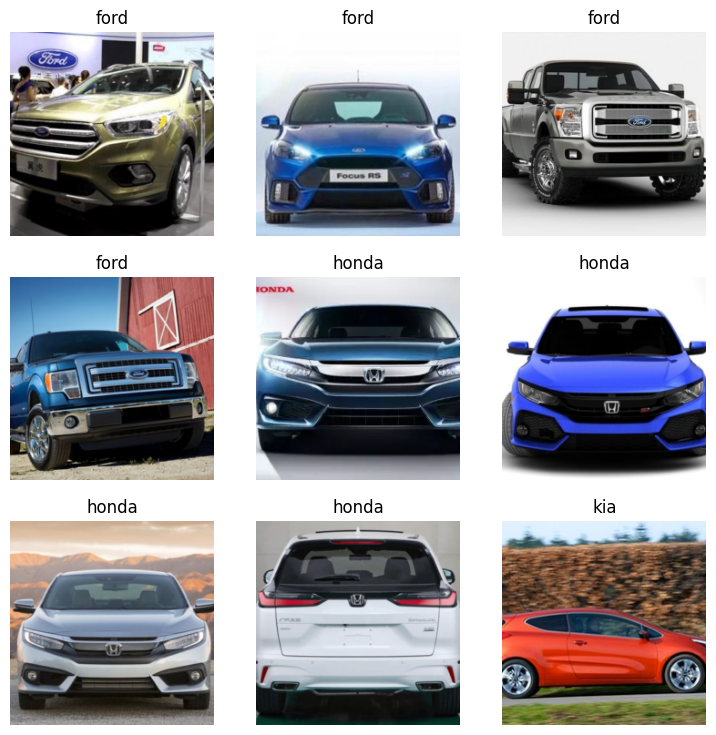

In [37]:
test_dl.show_batch()

In [38]:
# preds, targets, decodes = learn.get_preds(dl=test_dl, with_decoded=True)
preds, targets = learn.get_preds(dl=test_dl)

In [39]:
from fastai.tabular.all import *

In [40]:
accuracy(preds, targets)

TensorBase(0.7931)

In [41]:
# Create the interpretation object using the from_learner method
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)

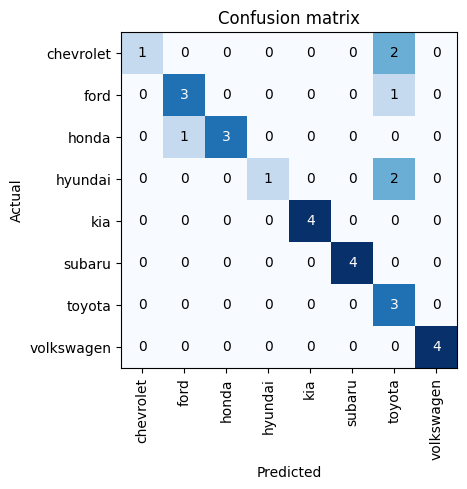

In [42]:
# Plot the confusion matrix
interp.plot_confusion_matrix()

In [43]:
# Show per-class metrics (e.g., precision, recall, F1-score)
interp.print_classification_report()

              precision    recall  f1-score   support

   chevrolet       1.00      0.33      0.50         3
        ford       0.75      0.75      0.75         4
       honda       1.00      0.75      0.86         4
     hyundai       1.00      0.33      0.50         3
         kia       1.00      1.00      1.00         4
      subaru       1.00      1.00      1.00         4
      toyota       0.38      1.00      0.55         3
  volkswagen       1.00      1.00      1.00         4

    accuracy                           0.79        29
   macro avg       0.89      0.77      0.77        29
weighted avg       0.90      0.79      0.80        29



In [45]:
model_path='cars.pkl'

In [47]:
learn.export(model_path)